# Classificação de textos do Twitter com spaCy

# Importação e instalação das bibliotecas

In [ ]:
#!pip install spacy --upgrade
!pip install -q spacy==2.2.3

     |████████████████████████████████| 10.4 MB 4.6 MB/s 
     |████████████████████████████████| 2.2 MB 41.8 MB/s 


In [ ]:
import spacy
spacy.__version__

'2.2.3'

In [ ]:
!python3 -m spacy download pt

     |████████████████████████████████| 21.2 MB 18.8 MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-py3-none-any.whl size=21186281 sha256=3ae4cfb0cb443d3ab06121b360bcf9365a960debb0bcb45e666083b5d1b6e18c
  Stored in directory: /tmp/pip-ephem-wheel-cache-a80bpd8q/wheels/c3/f9/0c/5c014a36941a00f5df5fc0756cb961d7c457a978e697a6ce3b
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [ ]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np
import re

# Carregamento das bases de dados

- Link Kaggle: https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis#TweetsNeutralHash.csv

## Base de treinamento

- Negative label: 0
- Positive label: 1

In [ ]:
base_treinamento = pd.read_csv('/content/Train50.csv', delimiter=';')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_treinamento.shape

(50000, 5)

In [ ]:
base_treinamento.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


In [ ]:
base_treinamento.tail()

,id,tweet_text,tweet_date,sentiment,query_used
49995,1046762827053232128,:( é tão lindo que dói https://t.co/GqnpgyWWxB,Mon Oct 01 14:04:40 +0000 2018,0,:(
49996,1046762813362966529,"@veraluciarj Pois é.. tenho problema c/ ""coisa...",Mon Oct 01 14:04:37 +0000 2018,0,:(
49997,1046762806392082432,eu te amo tanto minja vidinha meu bem mais pre...,Mon Oct 01 14:04:35 +0000 2018,0,:(
49998,1046762752071618560,@itsLary @jessboluda Pfvor :(,Mon Oct 01 14:04:22 +0000 2018,0,:(
49999,1046762735340584962,@Renk_lol Passa ano Entra ano Eu nao desisto d...,Mon Oct 01 14:04:18 +0000 2018,0,:(


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


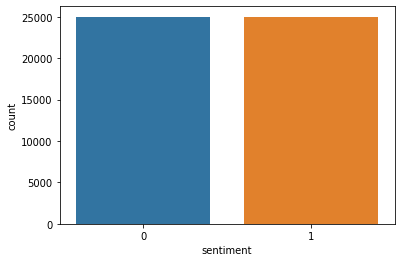

In [ ]:
sns.countplot(base_treinamento['sentiment'], label = 'Contagem');

In [ ]:
base_treinamento.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [ ]:
base_treinamento.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1


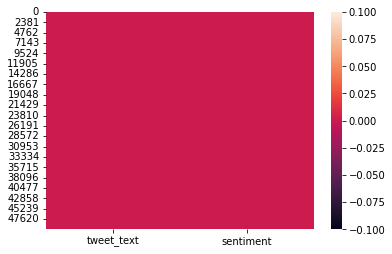

In [ ]:
sns.heatmap(pd.isnull(base_treinamento));

## Base de teste

In [ ]:
base_teste = pd.read_csv('/content/Test.csv', delimiter=';')

In [ ]:
base_teste.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,1,:)


In [ ]:
base_teste.shape

(5000, 5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


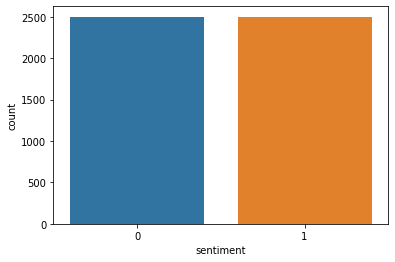

In [ ]:
sns.countplot(base_teste['sentiment'], label='Contagem');

In [ ]:
base_teste.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [ ]:
base_teste.head()

,tweet_text,sentiment
0,@Gazo1a Nossa! Muito obrigada :),1
1,@BerzGamer vai pa puta que te pariu :),1
2,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,1
3,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",1
4,Estávamos em casa do Zé e eu estava a morrer d...,1


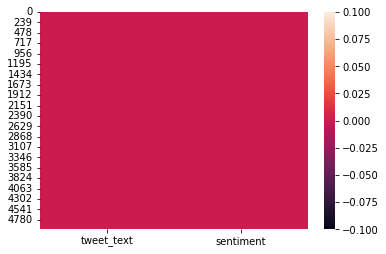

In [ ]:
sns.heatmap(pd.isnull(base_teste));

# Função para pré-processamento dos textos

- Letras minúsculas
- Nome do usuário (@)
- URLs
- Espaços em branco
- Emoticons
- Stop words
- Lematização
- Pontuações

In [ ]:
pln = spacy.load('pt')
pln

In [ ]:
base_treinamento['tweet_text'][1]

'@behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)'

In [ ]:
stop_words = spacy.lang.pt.stop_words.STOP_WORDS

In [ ]:
print(stop_words)

{'fora', 'obrigada', 'nove', 'tanta', 'das', 'à', 'nos', 'todos', 'isto', 'dar', 'oitava', 'debaixo', 'lugar', 'ora', 'valor', 'tuas', 'ele', 'bastante', 'vários', 'fazer', 'ontem', 'deste', 'teus', 'todo', 'umas', 'algo', 'estiveram', 'nada', 'baixo', 'tive', 'tem', 'teve', 'diante', 'menos', 'também', 'catorze', 'com', 'num', 'podem', 'primeira', 'aquelas', 'fostes', 'ali', 'vez', 'último', 'outras', 'pegar', 'novo', 'fim', 'estará', 'vai', 'aqueles', 'duas', 'dizer', 'vós', 'corrente', 'nas', 'adeus', 'vão', 'tivemos', 'cá', 'você', 'estiveste', 'sempre', 'oito', 'não', 'estado', 'caminho', 'uns', 'numa', 'área', 'todas', 'qual', 'novos', 'cuja', 'em', 'sabe', 'sois', 'põe', 'vem', 'eles', 'faço', 'isso', 'mês', 'direita', 'veja', 'esta', 'tempo', 'momento', 'assim', 'forma', 'outra', 'acerca', 'para', 'vosso', 'posição', 'terceira', 'desde', 'tua', 'vais', 'neste', 'falta', 'aqui', 'puderam', 'tentaram', 'estar', 'depois', 'ambas', 'poderá', 'maioria', 'tais', 'maior', 'pouco', 'el

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def preprocessamento(texto):
  # Letras minúsculas
  texto = texto.lower()

  # Nome do usuário
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)

  # URLs
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)

  # Espaços em branco
  texto = re.sub(r" +", ' ', texto)

  # Emoticons
  lista_emocoes = {':)': 'emocaopositiva',
                   ':d': 'emocaopositiva',
                   ':(': 'emocaonegativa'}
  for emocao in lista_emocoes:
    texto = texto.replace(emocao, lista_emocoes[emocao])

  # Lematização
  documento = pln(texto)

  lista = []
  for token in documento:
    lista.append(token.lemma_)
  
  # Stop words e pontuações
  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  
  return lista

In [ ]:
texto_teste = '@behin_d_curtain :D Para :( mim, http://www.iaexpert.com.br é precisamente o contrário :) Vem a chuva e vem a boa disposição :)'
resultado = preprocessamento(texto_teste)
resultado

'  emocaopositiva parir emocaonegativa mim precisamente o contrário emocaopositiva vir o chuva e vir o disposição emocaopositiva'

# Pré-processamento da base de dados

### Limpeza dos textos

In [ ]:
base_treinamento.head(10)

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1
5,@KingJokerLeto mas amiga eu to aqui ainda :),1
6,"@RivasJairo Bravo, Jairo!!! :)))",1
7,@inquilinasls @Spotify socorro ksoaksosks acho...,1
8,"@chimekarlla gosto muito de fazenda :) , mas m...",1
9,Amanha vou ver venom :D,1


In [ ]:
base_treinamento['tweet_text'] = base_treinamento['tweet_text'].apply(preprocessamento)

In [ ]:
base_treinamento.head(10)

,tweet_text,sentiment
0,o pessoa certo parir seriar o valer e azeved...,1
1,parir mim precisamente o contrário emocaopos...,1
2,video hoje ... pensar falar sobrar o meter csg...,1
3,aaaaaaaa amar polaroids expressar o quantum to...,1
4,valorizar o coração menino vc diferente o sorr...,1
5,amigo to emocaopositiva,1
6,bravo jairo emocaopositiva,1
7,socorrer ksoaksosks achar to o caixa som :p,1
8,gostar fazenda emocaopositiva morrer medo ga...,1
9,amanhar venom emocaopositiva,1


In [ ]:
base_teste['tweet_text'] = base_teste['tweet_text'].apply(preprocessamento)

In [ ]:
base_teste.head(10)

,tweet_text,sentiment
0,obrigar emocaopositiva,1
1,pa puta parir emocaopositiva,1
2,querer desconto 14/08 ⭐ ⭐ ⭐ ⭐ ⭐ 🌐 conferir o l...,1
3,vcs ajudar galera pelar amor butera emocaoposi...,1
4,casar zé e o morrer sono chegar o casar e fica...,1
5,preciso emocaopositiva,1
6,acaso adorar beijo e abraço hahahahaha bue f...,1
7,solteiro s emocaopositiva,1
8,lindeza cortador kit mário coleção bia cravol ...,1
9,claro emocaopositiva,1


### Tratamento da classe

In [ ]:
exemplo_base_dados = [["este trabalho é agradável", {"POSITIVO": True, "NEGATIVO": False}],
                      ["este lugar continua assustador", {"POSITIVO": False, "NEGATIVO": True}]]

In [ ]:
base_dados_treinamento_final = []
for texto, emocao in zip(base_treinamento['tweet_text'], base_treinamento['sentiment']):
  if emocao == 1:
    dic = ({'POSITIVO': True, 'NEGATIVO': False})
  elif emocao == 0:
    dic = ({'POSITIVO': False, 'NEGATIVO': True})

  base_dados_treinamento_final.append([texto, dic.copy()])

In [ ]:
len(base_dados_treinamento_final)

50000

In [ ]:
base_dados_treinamento_final[10:15]

[['simplesmente o deixar chatear querer muitooo e iludir emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['o comedir umar rotina e perfeitamente parir consolidar o escola condução :p',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['amigar parecer apaixonar vc — recíproco emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['  gajar bacano aleijar esperar e o silvar feliz emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['tou o video cabra bebé emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}]]

In [ ]:
base_dados_treinamento_final[45000:45005]

[['o menino pijama listrar o filmar triste mundo estruturar nenhum pra assistir rever e to pensar n emocaonegativa',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['pra o vídeo luísa raiz o poliana infelizmente o twitter tá ruim amanhã postar emocaonegativa asaventurasdepoliana099',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['to crise abstinência strangers emocaonegativa — tbm :/ to',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['  esquecer olhar pra pagar o mensalidade turma pro cursar querer emocaonegativa',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['querer comer doce comer montar hoje emocaonegativa maldição',
  {'NEGATIVO': True, 'POSITIVO': False}]]

# Criação do classificador

In [ ]:
modelo = spacy.blank('pt')
categorias = modelo.create_pipe("textcat")
categorias.add_label("POSITIVO")
categorias.add_label("NEGATIVO")
modelo.add_pipe(categorias)
historico = []

In [ ]:
modelo.begin_training()
for epoca in range(20):
  random.shuffle(base_dados_treinamento_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_treinamento_final, 512):
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    modelo.update(textos, annotations, losses=losses)
    historico.append(losses)
  if epoca % 5 == 0:
    print(losses)

{'textcat': 6.925878533028951e-06}
{'textcat': 2.828117112736034e-07}
{'textcat': 5.964938874325303e-08}
{'textcat': 4.485299253043822e-08}


In [ ]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))

In [ ]:
historico_loss = np.array(historico_loss)
historico_loss

array([6.92587853e-06, 6.92587853e-06, 6.92587853e-06, ...,
       4.48174852e-08, 4.48174852e-08, 4.48174852e-08])

Text(0, 0.5, 'Erro')

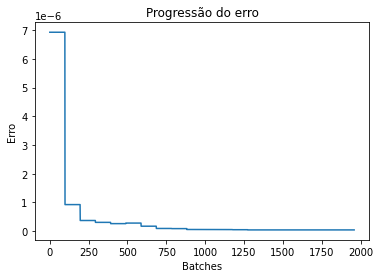

In [ ]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')

In [ ]:
modelo.to_disk("modelo")

# Testes com uma frase

In [ ]:
modelo_carregado = spacy.load('modelo')
modelo_carregado

## Texto positivo

In [ ]:
texto_positivo = base_teste['tweet_text'][21]
texto_positivo

'  ficar feliz q recíproco emocaopositiva'

In [ ]:
previsao = modelo_carregado(texto_positivo)
previsao

  ficar feliz q recíproco emocaopositiva

In [ ]:
previsao.cats

{'NEGATIVO': 4.539786823443137e-05, 'POSITIVO': 0.9999545812606812}

In [ ]:
texto_positivo = 'eu gosto muito de você'
texto_positivo = preprocessamento(texto_positivo)
texto_positivo

'gostar'

In [ ]:
modelo_carregado(texto_positivo).cats

{'NEGATIVO': 0.026432260870933533, 'POSITIVO': 0.9160122871398926}

## Texto negativo

In [ ]:
base_teste['tweet_text'][4000]

'tô triste filmar mulan o mushu emocaonegativa'

In [ ]:
texto_negativo = base_teste['tweet_text'][4000]
previsao = modelo_carregado(texto_negativo)
previsao.cats

{'NEGATIVO': 0.9956915974617004, 'POSITIVO': 0.0007994209881871939}

# Avaliação do modelo

## Avaliação na base de treinamento


In [ ]:
previsoes = []
for texto in base_treinamento['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [ ]:
previsoes

[{'NEGATIVO': 6.014708196744323e-05, 'POSITIVO': 0.9998656511306763},
 {'NEGATIVO': 4.539786823443137e-05, 'POSITIVO': 0.9999545812606812},
 {'NEGATIVO': 4.539786823443137e-05, 'POSITIVO': 0.9999545812606812},
 {'NEGATIVO': 4.539786823443137e-05, 'POSITIVO': 0.9999545812606812},
 {'NEGATIVO': 4.539786823443137e-05, 'POSITIVO': 0.9999545812606812},
 {'NEGATIVO': 8.89400253072381e-05, 'POSITIVO': 0.9998146891593933},
 {'NEGATIVO': 0.00020334727014414966, 'POSITIVO': 0.9983733892440796},
 {'NEGATIVO': 4.539786823443137e-05, 'POSITIVO': 0.9999545812606812},
 {'NEGATIVO': 0.0002625312772579491, 'POSITIVO': 0.9996039271354675},
 {'NEGATIVO': 0.0005516020464710891, 'POSITIVO': 0.999866247177124},
 {'NEGATIVO': 4.539786823443137e-05, 'POSITIVO': 0.9999508857727051},
 {'NEGATIVO': 4.539786823443137e-05, 'POSITIVO': 0.9999545812606812},
 {'NEGATIVO': 4.539786823443137e-05, 'POSITIVO': 0.9999545812606812},
 {'NEGATIVO': 4.539786823443137e-05, 'POSITIVO': 0.9999545812606812},
 {'NEGATIVO': 9.06662

In [ ]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [ ]:
previsoes_final

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
respostas_reais = base_treinamento['sentiment'].values
respostas_reais

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(respostas_reais, previsoes_final)

0.99994

In [ ]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[24997,     3],
       [    0, 25000]])

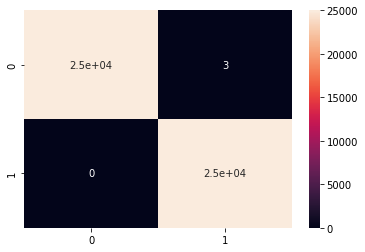

In [ ]:
sns.heatmap(cm, annot=True)

## Avaliação na base de teste

In [ ]:
previsoes = []
for texto in base_teste['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [ ]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [ ]:
respostas_reais = base_teste['sentiment'].values

In [ ]:
accuracy_score(respostas_reais, previsoes_final)

0.9972

In [ ]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[2494,    6],
       [   8, 2492]])

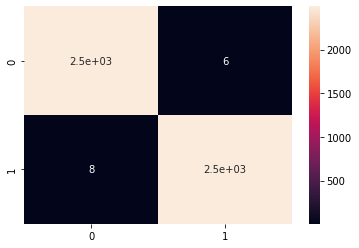

In [ ]:
sns.heatmap(cm, annot=True)